In [1]:
import os
import torch
from torchvision import transforms
from torch.utils import data
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import sys 
sys.path.append('..')
from den import DEN
from dataset import NyuV2
import utils
import transforms_nyu

%matplotlib inline

In [2]:
data_path = '../data/nyu_v2/'
batch_size = 16
depth_size = (25, 32)
test_crop = (427, 561)
seed = 2
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transformers = {
    'train': transforms.Compose([transforms_nyu.Scale(),
                                 transforms_nyu.RandomRescale(0.1),
                                 transforms_nyu.RandomRotate(10),
                                 transforms_nyu.RandomCrop(test_crop),
                                 transforms_nyu.RandomHorizontalFlip(0.5),
                                 transforms_nyu.ToTensor()]),

    'val': transforms.Compose([transforms_nyu.Scale(),
                               transforms_nyu.CenterCrop(test_crop),
                               transforms_nyu.ToTensor()])
}

nyu = {
    'train': NyuV2(os.path.join(data_path, 'train'), transform=transformers['train']),

    'val': NyuV2(os.path.join(data_path, 'val'), transform=transformers['val'])
}

dataloaders = {
    'train': data.DataLoader(nyu['train'], num_workers=8,
                             batch_size=batch_size, shuffle=True),
    
    'val': data.DataLoader(nyu['val'], num_workers=8,
                           batch_size=batch_size, shuffle=True)
}

In [4]:
wts = '../models/resnet_crop_427/092_model.pt'
# model_file = '../models/den_dbe/008_model.pt'
den = DEN(wts)
# den.load_state_dict(torch.load(model_file))
den = den.to(device)

In [5]:
params_to_update = []
for name,param in den.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 fc.weight
	 fc.bias
	 aux_modules.0.aux.0.weight
	 aux_modules.0.aux.0.bias
	 aux_modules.0.aux.3.weight
	 aux_modules.0.aux.3.bias
	 aux_modules.1.aux.0.weight
	 aux_modules.1.aux.0.bias
	 aux_modules.1.aux.3.weight
	 aux_modules.1.aux.3.bias
	 aux_modules.2.aux.0.weight
	 aux_modules.2.aux.0.bias
	 aux_modules.2.aux.3.weight
	 aux_modules.2.aux.3.bias
	 aux_modules.3.aux.0.weight
	 aux_modules.3.aux.0.bias
	 aux_modules.3.aux.3.weight
	 aux_modules.3.aux.3.bias
	 aux_modules.4.aux.0.weight
	 aux_modules.4.aux.0.bias
	 aux_modules.4.aux.3.weight
	 aux_modules.4.aux.3.bias
	 aux_modules.5.aux.0.weight
	 aux_modules.5.aux.0.bias
	 aux_modules.5.aux.3.weight
	 aux_modules.5.aux.3.bias
	 aux_modules.6.aux.0.weight
	 aux_modules.6.aux.0.bias
	 aux_modules.6.aux.3.weight
	 aux_modules.6.aux.3.bias
	 aux_modules.7.aux.0.weight
	 aux_modules.7.aux.0.bias
	 aux_modules.7.aux.3.weight
	 aux_modules.7.aux.3.bias
	 aux_modules.8.aux.0.weight
	 aux_modules.8.aux.0.bias
	 aux_modules.8.aux.3.weig

In [6]:
img = torch.Tensor(1, 3, 224, 224).normal_()

In [10]:
d_hat = den(img.float())

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'weight'

In [ ]:
d_hat.shape

In [ ]:
utils.plot_grad_flow(den.aux_modules.named_parameters(), 'd')

In [22]:
def evaluate(model):
    model.eval()
    test_loss = 0
    for batch, sample in enumerate(dataloaders['val']):
        data = sample['image'].to(device).float()
        labels = sample['depth'].to(device).float()
        depth_maps = model(data)
        loss = F.mse_loss(depth_maps, labels, reduction='sum')
        test_loss += loss.item()
    
    return (test_loss / len(dataloaders['val'].dataset))**0.5

In [23]:
evaluate(den)

11.472562216583466

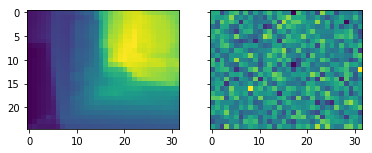

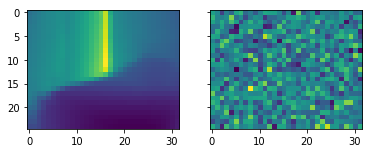

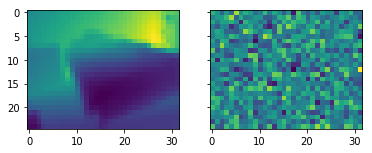

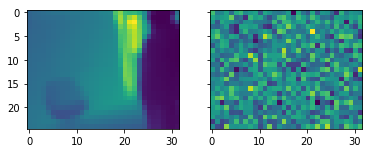

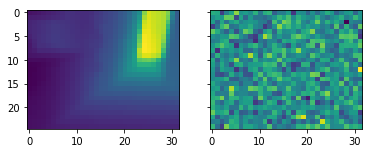

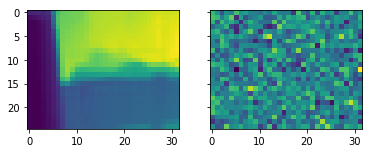

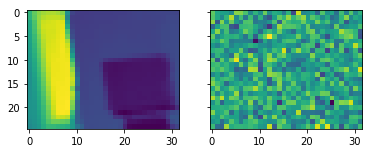

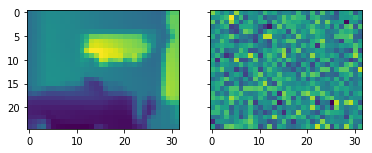

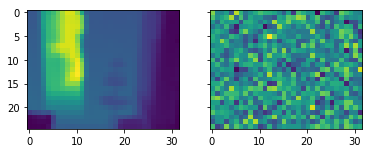

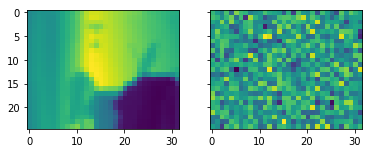

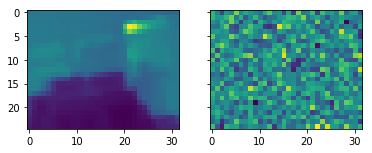

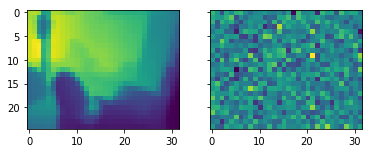

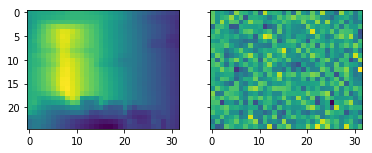

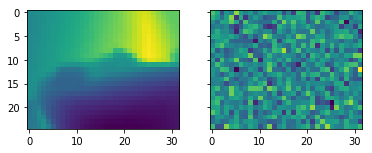

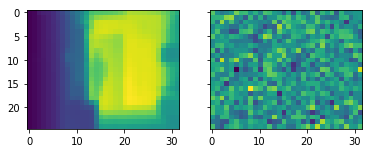

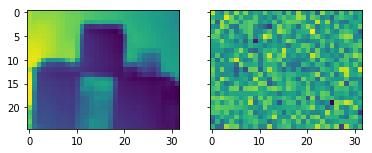

In [21]:
sample = next(iter(dataloaders['train']))
d = sample['depth']
den.eval()
d_pred = den(sample['image'].to(device).float())

for i in range(batch_size):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(d[i].view(depth_size))
    ax2.imshow(d_pred[i].view(depth_size).cpu().data.numpy())